In [1]:
from micrograd.engine import Value
from micrograd.nn import MLP, Layer, Neuron
from micrograd.viz import draw_dot

import torch
import random
import numpy as np
import matplotlib.pyplot as plt

In [15]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

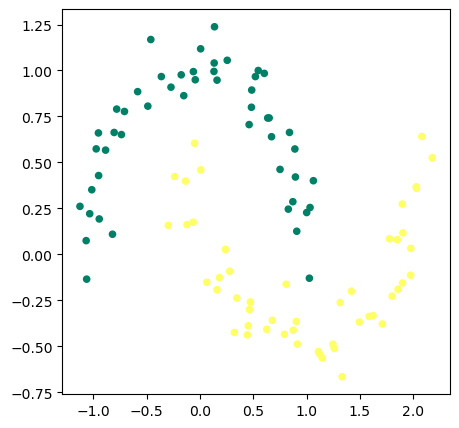

In [11]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 100, noise = 0.1)

y = y*2-1

plt.figure(figsize = (5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='summer')

In [17]:
model = MLP(2, [16, 16, 1])
print(model)
print("# parameters: ", len(model.parameters()))

MLP of [Layer of [ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2), ReLU Neuron(2)], Layer of [ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16), ReLU Neuron(16)], Layer of [ReLU Neuron(16)]]
# parameters:  337


In [23]:
def loss(batch_size = None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    inputs = [list(map(Value, xrow)) for xrow in Xb]
    scores = list(map(model, inputs))

    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0/len(losses))

    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy)/len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data = 0.8655474959949557, grad = 0.0) 0.51


In [25]:
for k in range(100):
    total_loss, acc = loss()

    model.zero_grad()
    total_loss.backward()

    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate*p.grad

    if k%10 == 0:
        print(f"Step {k} -> loss: {total_loss.data}, accuracy: {acc*100}%")

Step 0 -> loss: 0.8655474959949557, accuracy: 51.0%
Step 10 -> loss: 0.27757878035847133, accuracy: 86.0%
Step 20 -> loss: 0.23341060688955495, accuracy: 89.0%
Step 30 -> loss: 0.1660479055434317, accuracy: 94.0%
Step 40 -> loss: 0.1005229128057448, accuracy: 99.0%
Step 50 -> loss: 0.07023408572540184, accuracy: 99.0%
Step 60 -> loss: 0.06089906633764387, accuracy: 99.0%
Step 70 -> loss: 0.05599957941512807, accuracy: 99.0%
Step 80 -> loss: 0.053128084351788195, accuracy: 99.0%
Step 90 -> loss: 0.05142171429201227, accuracy: 99.0%


(-1.6649204204278356, 2.0850795795721644)

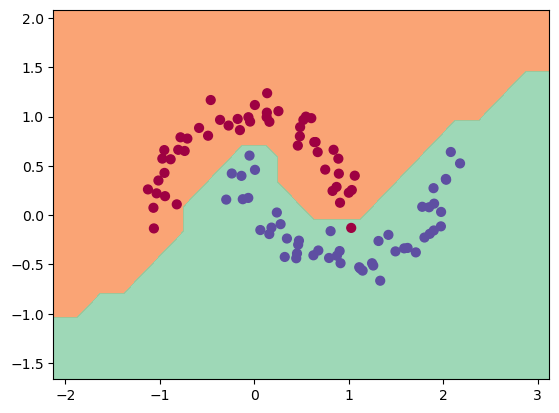

In [27]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))

Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral, alpha = 0.8)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 40, cmap = plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

## PyTorch

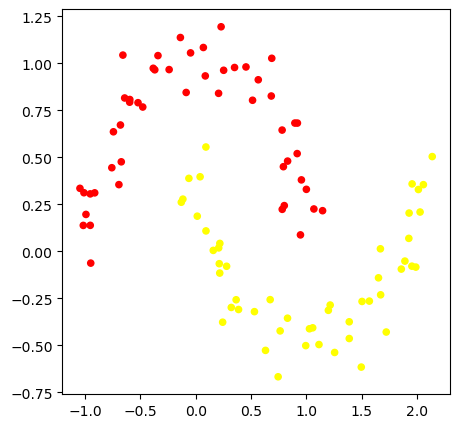

In [54]:
X, y = make_moons(n_samples = 100, noise = 0.1)

X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y*2-1, dtype = torch.float32)

plt.figure(figsize = (5, 5))
plt.scatter(X[:, 0], X[:, 1], c = y, s = 20, cmap = 'autumn')

In [56]:
model_torch = torch.nn.Sequential(
            torch.nn.Linear(2, 16), torch.nn.ReLU(),
            torch.nn.Linear(16, 16), torch.nn.ReLU(),
            torch.nn.Linear(16, 1)
        )

print(model_torch)
print("# parameters: ", sum(p.numel() for p in model_torch.parameters()))

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)
# parameters:  337


In [94]:
def loss_torch(batch_size = None):
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = torch.randint(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    scores = model_torch(Xb).squeeze(dim = -1)

    losses = torch.nn.functional.relu(1 - yb * scores)
    data_loss = losses.mean()
    
    alpha = 1e-4
    reg_loss = alpha * sum((p**2).sum() for p in model_torch.parameters())
    total_loss = data_loss + reg_loss

    accuracy = ((scores>0).float() == (yb>0).float()).float().mean()

    return total_loss, accuracy

total_loss, acc = loss_torch()
print(total_loss.item(), acc.item())

1.0430705547332764 0.5


In [96]:
for k in range(100):
    total_loss, acc = loss_torch()

    model_torch.zero_grad()
    total_loss.backward()

    learning_rate = 1.0 - 0.9*k/100
    with torch.no_grad():
        for p in model_torch.parameters():
            p -= learning_rate*p.grad

    if k%10 == 0:
        print(f"Step {k} -> loss: {total_loss.item()}, accuracy: {acc.item()*100}%")

Step 0 -> loss: 1.0430705547332764, accuracy: 50.0%
Step 10 -> loss: 0.26658129692077637, accuracy: 87.00000047683716%
Step 20 -> loss: 0.2509198784828186, accuracy: 87.99999952316284%
Step 30 -> loss: 0.21788057684898376, accuracy: 89.99999761581421%
Step 40 -> loss: 0.21536734700202942, accuracy: 88.99999856948853%
Step 50 -> loss: 0.19988800585269928, accuracy: 91.00000262260437%
Step 60 -> loss: 0.16263215243816376, accuracy: 92.00000166893005%
Step 70 -> loss: 0.13527603447437286, accuracy: 94.9999988079071%
Step 80 -> loss: 0.11485253274440765, accuracy: 95.99999785423279%
Step 90 -> loss: 0.09665646404027939, accuracy: 97.00000286102295%


(-1.667189598083496, 2.082810401916504)

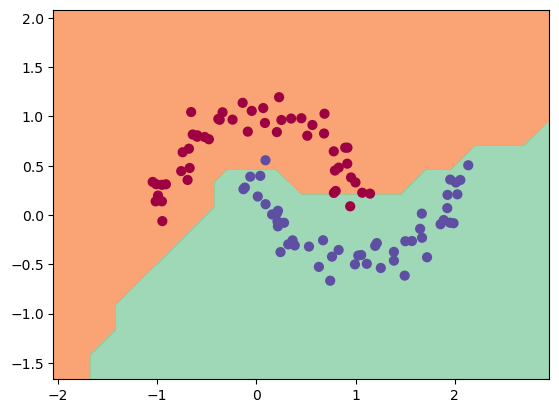

In [98]:
h = 0.25
x_min, x_max = X[:, 0].min().item() - 1, X[:, 0].max().item() + 1
y_min, y_max = X[:, 1].min().item() - 1, X[:, 1].max().item() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Xmesh = np.c_[xx.ravel(), yy.ravel()]
Xmesh_tensor = torch.tensor(Xmesh, dtype = torch.float32)
with torch.no_grad():
    scores = model_torch(Xmesh_tensor).squeeze(dim = -1)

Z = (scores>0).numpy()
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral, alpha = 0.8)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 40, cmap = plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())